In [1]:
import torch

class NonlinearTransform(torch.nn.Module):
    def __init__(self, coefficients):
        super(NonlinearTransform, self).__init__()
        self.coefficients = coefficients
    
    def forward(self, x):
        return torch.cat([
            torch.stack([coeff * torch.tanh((power + 1) * x[..., i:i + 1]**power) for power, coeff in enumerate(self.coefficients[i])]).sum(dim=0)
            for i in range(x.shape[-1])
        ], dim=-1)

    def inverse(self, y, tol=1e-6, max_iter=10000):
        # Initialize x with y as an approximation (you can improve this)
        x = y.clone()
        
        for _ in range(max_iter):
            f_x = self.forward(x)
            diff = y - f_x
            if torch.norm(diff) < tol:
                break
            
            # Update x using a numerical method, like Newton's method
            # Here you would compute the Jacobian or use a simpler gradient-based update
            # For simplicity, we just do a fixed-step gradient descent update
            x = x + diff * 0.1  # Step size 0.1; could be adaptive
            
        return x

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class LineFitter(nn.Module):
    def __init__(self):
        super(LineFitter, self).__init__()
        self.slopes = nn.ParameterList()
        self.intercepts = nn.ParameterList()

    def check_straightness(self, y, x):
        """
        Fit a line to y = function(x) and calculate the mean squared error (MSE)
        between y and the fitted line.
        """
        # Flatten x and y
        x_flat = x.flatten()
        y_flat = y.flatten()

        # Stack x with ones for linear regression (adding bias term)
        X = torch.stack([x_flat, torch.ones_like(x_flat)], dim=1)

        # Solve for slope and intercept using least squares
        params = torch.linalg.lstsq(X, y_flat).solution
        slope, intercept = params[0], params[1]

        # Predict y using the fitted line
        y_pred = slope * x + intercept

        # Calculate the MSE between the actual and predicted y
        mse = F.mse_loss(y_pred, y)

        return mse, slope, intercept

    def fit(self, f, x):
        """
        Fits a line to each component of (x, y) data and stores the slope and intercept as nn.Parameters.

        Args:
            y: A tensor of outputs (transformed x).
            x: A tensor of inputs (each component will be fit separately).

        Returns:
            mse_values: A tensor containing the MSE for each component.
        """
        num_components = x.shape[-1]
        mse_values = []

        # Clear previous slopes and intercepts
        self.slopes = nn.ParameterList()  # Reset to a new ParameterList
        self.intercepts = nn.ParameterList()  # Reset to a new ParameterList

        y = f(x)
        # Fit each component of x and y independently
        for i in range(num_components):
            x_component = x[:, i:i + 1]  # Select the i-th component of x
            y_component = y[:, i:i + 1]  # Select the i-th component of y

            # Perform the linear fit on the selected component
            mse, slope, intercept = self.check_straightness(y_component, x_component)

            # Store slope and intercept as nn.Parameters
            self.slopes.append(nn.Parameter(slope.unsqueeze(0)))  # Ensure it's a 1D tensor
            self.intercepts.append(nn.Parameter(intercept.unsqueeze(0)))

            # Save the MSE for this component
            mse_values.append(mse)

        mse_values = torch.tensor(mse_values)  # Convert MSE values to a tensor

        return mse_values

    def forward(self, x):
        """
        Forward pass applying the linear transformation for each component of x.
        """
        if len(self.slopes) == 0 or len(self.intercepts) == 0:
            raise ValueError("Slopes and intercepts are not initialized. Call fit_and_return_functions first.")

        transformed_components = [
            self.slopes[i] * x[..., i:i + 1] + self.intercepts[i]
            for i in range(x.shape[-1])
        ]
        return torch.cat(transformed_components, dim=-1)

In [1]:
import torch
import matplotlib.pyplot as plt
from src.utils import plot_components

num_points = 100
observed_dim = 3
degree = 5

x = torch.randn(num_points, observed_dim).abs()
# x = torch.linspace(0, 1, 100).unsqueeze(-1)

coefficients = torch.rand(observed_dim, degree + 1)
transformation = NonlinearTransform(coefficients)

fitter = LineFitter()
adl = fitter.fit(transformation, x)

# plt.scatter(x, transformation(x))
# plt.scatter(x, fitter(x).detach())
plot_components(x, transformation)

# y_inv = transformation.inverse(y)
# plt.scatter(x, y_inv)

NameError: name 'NonlinearTransform' is not defined

In [11]:
# # Define a linear function
# def linear_function(x):
#     return 2 * x + 1
# 
# # Define a nonlinear function
# def nonlinear_function(x):
#     return 2 * x + 3 + 10 * torch.sin(x)
# 
# # Use 1D input for this example
# x = torch.linspace(-10, 10, steps=100).unsqueeze(-1)  # Ensure x is 1D
# 
# # Check the MSE for the linear function
# mse_linear = fitter.fit(linear_function, x)
# print(f"MSE for linear function: {mse_linear.item()}")
# 
# # Check the MSE for the nonlinear function
# mse_nonlinear, _, _ = fitter.fit(nonlinear_function, x)
# print(f"MSE for nonlinear function: {mse_nonlinear.item()}")

tensor([[0.0000],
        [0.4621],
        [0.7616],
        [0.9051],
        [0.9640]])
1


tensor([[0.0000],
        [0.4621],
        [0.7616],
        [0.9051],
        [0.9640]])
tensor([[0.0000],
        [0.5000],
        [1.0000],
        [1.5000],
        [2.0000]])


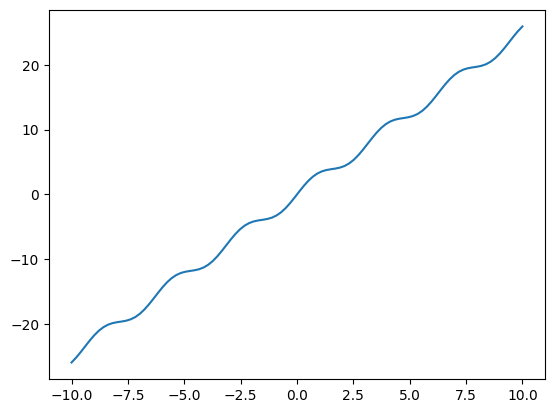

In [1]:
import torch

x = torch.tensor([0, 0.5, 1, 1.5, 2]).unsqueeze(-1)
z = torch.tanh(x)
y = torch.atanh(z)
print(z)
print(y)
import matplotlib.pyplot as plt

x = torch.linspace(-10, 10, 100)
y = torch.sin(2 * x) + 2.5 * x

plt.plot(x, y)

In [ ]:
from src.modules.metric.residual_nonlinearity import LineFitter
from src.modules.transform import NonlinearComponentWise
from src.modules.metric.residual_nonlinearity import plot_components

import torch
import matplotlib.pyplot as plt

num_points = 100
observed_dim = 4
latent_dim = 4
degree = 5

x = torch.randn(num_points, observed_dim).abs() / 2
# x = torch.linspace(0, 1, 100).unsqueeze(-1)

coefficients = torch.rand(observed_dim, degree + 1)
transformation = NonlinearComponentWise(observed_dim=observed_dim, nonlinearity='cnae', latent_dim=latent_dim, degree=degree)

fitter = LineFitter()
adl = fitter.fit(transformation, x)

# plt.scatter(x, transformation(x))
# plt.scatter(x, fitter(x).detach())
plot_components(x, trasnformation=transformation, fitter=fitter)